In [393]:
import sys
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset, WeakDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    plot_losses,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

In [416]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 1000,
    "batch_size": 50,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2,
    "iter_d":1,
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':100,
    'n_samples_weak':900,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_weak']\
                +cfg_dataset['n_samples_test'],
    'n_features':50,
    'n_informative':30,
    'n_targets':5,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [417]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])

X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=min(cfg["batch_size"], cfg_dataset["n_samples_train"]), device=cfg["device"])

In [418]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)
optimD = Adam(netD.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

L2 = nn.MSELoss()

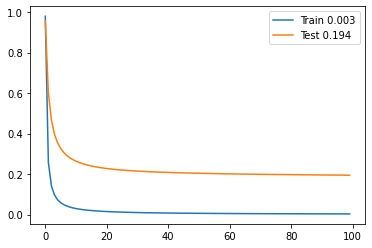

In [419]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())


    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)

        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
        
        plt.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        plt.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        
        plt.legend()
        plt.show()

In [64]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)
optimD = Adam(netD.parameters(), lr=1e-2)
optimG = Adam(netR.parameters(), lr=1e-3)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

schedR = torch.optim.lr_scheduler.ExponentialLR(optimR, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

L2 = nn.MSELoss()
cfg["iter_d"] = 10

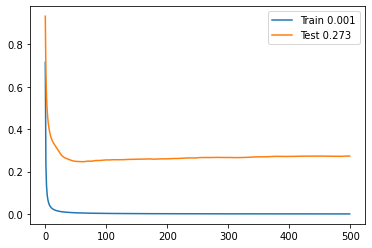

In [65]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()
        meters["L2_Loss_Train"].update(loss.item())

        ### Descriminator
        for j in range(cfg['iter_d']):
            optimD.zero_grad()
            X_batch_weak = weak_loader.sample()

            with torch.no_grad():
                fake = netR(X_batch_weak)
                real = y_batch

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            netD_total_loss.backward()
            optimD.step()
        
        optimG.zero_grad()
        optimD.zero_grad()
        optimR.zero_grad()
        
        fake = netR(X_batch_weak)
        netG_pred = netD(fake)
        netG_loss = -netG_pred.mean()
        netG_loss_total = 0.01*netG_loss
        netG_loss_total.backward()
        optimG.step()



    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)

        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
        
        plt.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        plt.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        
        plt.legend()
        plt.show()

#### Experiments

In [277]:
results_regr = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(loss.item())


        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr["Train"].append(losses[0])
    results_regr["Test"].append(losses[1])

Train 0.001, Test 0.266: 100% 2500/2500 [00:04<00:00, 597.32it/s]
Train 0.002, Test 0.320: 100% 2500/2500 [00:04<00:00, 598.86it/s]
Train 0.002, Test 0.274: 100% 2500/2500 [00:03<00:00, 645.69it/s]
Train 0.001, Test 0.264: 100% 2500/2500 [00:03<00:00, 678.07it/s]
Train 0.002, Test 0.272: 100% 2500/2500 [00:03<00:00, 639.26it/s]
Train 0.002, Test 0.282: 100% 2500/2500 [00:03<00:00, 645.76it/s]
Train 0.001, Test 0.258: 100% 2500/2500 [00:03<00:00, 633.36it/s]
Train 0.002, Test 0.259: 100% 2500/2500 [00:04<00:00, 572.08it/s]
Train 0.001, Test 0.299: 100% 2500/2500 [00:04<00:00, 567.08it/s]
Train 0.001, Test 0.328: 100% 2500/2500 [00:04<00:00, 578.29it/s]
Train 0.001, Test 0.269: 100% 2500/2500 [00:04<00:00, 587.21it/s]
Train 0.001, Test 0.353: 100% 2500/2500 [00:04<00:00, 577.86it/s]
Train 0.001, Test 0.260: 100% 2500/2500 [00:04<00:00, 580.94it/s]
Train 0.001, Test 0.284: 100% 2500/2500 [00:04<00:00, 577.31it/s]
Train 0.001, Test 0.272: 100% 2500/2500 [00:04<00:00, 585.66it/s]
Train 0.00

In [122]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])
X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=min(cfg["batch_size"], cfg_dataset["n_samples_train"]), device=cfg["device"])

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

In [123]:
cfg["iter_d"] = 20

In [ ]:
results_regr_with_gan = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    optimD = Adam(netD.parameters(), lr=1e-2)
    optimG = Adam(netR.parameters(), lr=1e-3)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Descriminator
            for j in range(cfg['iter_d']):
                optimD.zero_grad()
                X_batch_weak = weak_loader.sample()

                with torch.no_grad():
                    fake = netR(X_batch_weak)
                    real = y_batch

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()

                netD_loss = e_fake - e_real

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                netD_total_loss.backward()
                optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            optimR.zero_grad()

            fake = netR(X_batch_weak)
            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            netG_loss_total = 0.01*netG_loss
            netG_loss_total.backward()
            optimG.step()
            
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()
            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr_with_gan["Train"].append(losses[0])
    results_regr_with_gan["Test"].append(losses[1])

Train 0.001, Test 0.228: 100% 5000/5000 [04:02<00:00, 20.62it/s]
Train 0.001, Test 0.225: 100% 5000/5000 [04:04<00:00, 20.48it/s]
Train 0.001, Test 0.271: 100% 5000/5000 [04:05<00:00, 20.35it/s]
Train 0.001, Test 0.235: 100% 5000/5000 [04:02<00:00, 20.64it/s]
Train 0.001, Test 0.400: 100% 5000/5000 [04:05<00:00, 20.34it/s]
Train 0.001, Test 0.268: 100% 5000/5000 [04:03<00:00, 20.50it/s]
Train 0.026, Test 0.302:   5% 239/5000 [00:11<03:47, 20.97it/s]

In [ ]:
results_regr_with_rand_gan = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    optimD = Adam(netD.parameters(), lr=1e-2)
    optimG = Adam(netR.parameters(), lr=1e-3)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Descriminator
            for j in range(cfg['iter_d']):
                optimD.zero_grad()
                X_batch_weak = weak_loader.sample()
                X_batch_weak *= torch.normal(1, 0.1, (X_batch_weak.shape), device=cfg['device'])

                with torch.no_grad():
                    fake = netR(X_batch_weak)
                    real = y_batch

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()

                netD_loss = e_fake - e_real

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                netD_total_loss.backward()
                optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            optimR.zero_grad()

            fake = netR(X_batch_weak)
            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            netG_loss_total = 0.01*netG_loss
            netG_loss_total.backward()
            optimG.step()
            
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()
            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr_with_rand_gan["Train"].append(losses[0])
    results_regr_with_rand_gan["Test"].append(losses[1])

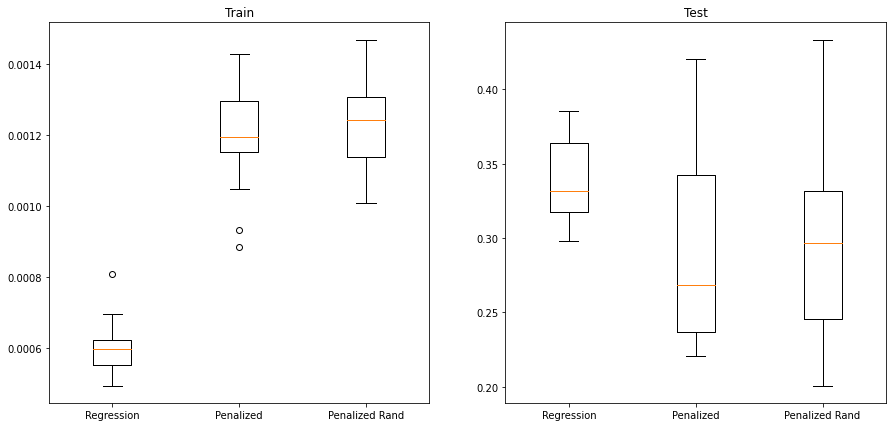

In [131]:
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title("Train")
ax1.boxplot([
    [i[-1] for i in results_regr["Train"]],
    [i[-1] for i in results_regr_with_gan["Train"]],
    [i[-1] for i in results_regr_with_rand_gan["Train"]]],
    labels = ["Regression", "Penalized", "Penalized Rand"]
)


ax2.set_title("Test")
ax2.boxplot([
    [i[-1] for i in results_regr["Test"]],
    [i[-1] for i in results_regr_with_gan["Test"]],
    [i[-1] for i in results_regr_with_rand_gan["Test"]]],
    labels = ["Regression", "Penalized", "Penalized Rand"]
)
plt.show()

In [ ]:
results_regr_with_gan_1e4 = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    optimD = Adam(netD.parameters(), lr=1e-2)
    optimG = Adam(netR.parameters(), lr=1e-4)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Descriminator
            for j in range(cfg['iter_d']):
                optimD.zero_grad()
                X_batch_weak = weak_loader.sample()

                with torch.no_grad():
                    fake = netR(X_batch_weak)
                    real = y_batch

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()

                netD_loss = e_fake - e_real

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                netD_total_loss.backward()
                optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            optimR.zero_grad()

            fake = netR(X_batch_weak)
            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            netG_loss_total = 0.01*netG_loss
            netG_loss_total.backward()
            optimG.step()
            
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()
            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr_with_gan_1e4["Train"].append(losses[0])
    results_regr_with_gan_1e4["Test"].append(losses[1])

Train 0.001, Test 0.174: 100% 5000/5000 [04:36<00:00, 18.09it/s]
Train 0.001, Test 0.209: 100% 5000/5000 [04:16<00:00, 19.48it/s]
Train 0.001, Test 0.213: 100% 5000/5000 [04:06<00:00, 20.32it/s]
Train 0.001, Test 0.267: 100% 5000/5000 [04:09<00:00, 20.06it/s]
Train 0.001, Test 0.210: 100% 5000/5000 [04:15<00:00, 19.55it/s]
Train 0.001, Test 0.350: 100% 5000/5000 [05:37<00:00, 14.83it/s]
Train 0.001, Test 0.258: 100% 5000/5000 [04:25<00:00, 18.83it/s]
Train 0.001, Test 0.190: 100% 5000/5000 [05:53<00:00, 14.16it/s]
Train 0.001, Test 0.292: 100% 5000/5000 [07:48<00:00, 10.68it/s]
Train 0.001, Test 0.142: 100% 5000/5000 [04:33<00:00, 18.26it/s]
Train 0.004, Test 0.174:  38% 1893/5000 [01:36<02:31, 20.52it/s]

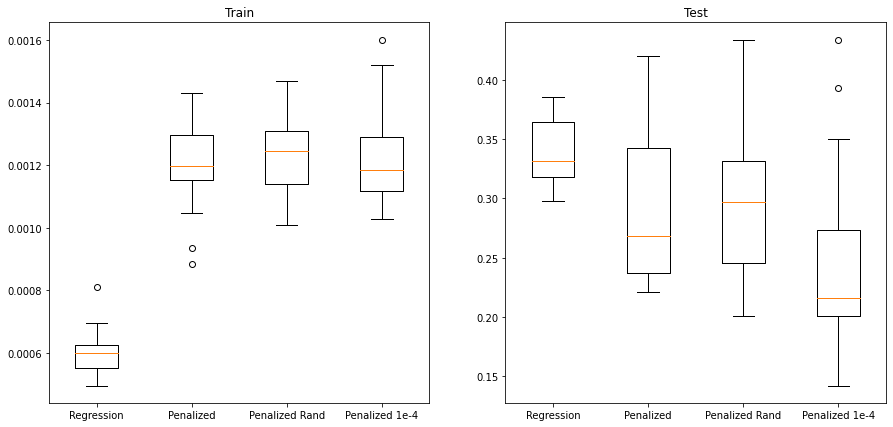

In [144]:
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title("Train")
ax1.boxplot([
    [i[-1] for i in results_regr["Train"]],
    [i[-1] for i in results_regr_with_gan["Train"]],
    [i[-1] for i in results_regr_with_rand_gan["Train"]],
    [i[-1] for i in results_regr_with_gan_1e4["Train"]]],
    labels = ["Regression", "Penalized", "Penalized Rand", "Penalized 1e-4"]
)


ax2.set_title("Test")
ax2.boxplot([
    [i[-1] for i in results_regr["Test"]],
    [i[-1] for i in results_regr_with_gan["Test"]],
    [i[-1] for i in results_regr_with_rand_gan["Test"]],
    [i[-1] for i in results_regr_with_gan_1e4["Test"]]],
    labels = ["Regression", "Penalized", "Penalized Rand", "Penalized 1e-4"]
)
plt.show()

### Normalizing flows RealNVP

In [4]:
from torch import distributions
from torch.nn.parameter import Parameter

In [5]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [6]:
nets = lambda: nn.Sequential(nn.Linear(2, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 1).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2).to(cfg["device"]), torch.eye(2).to(cfg["device"]))
flow = RealNVP(nets, nett, masks, prior)

flow = flow.to(cfg["device"])
dataset_y_all = WeakDataset(y, batch_size=100, device=cfg["device"])

In [7]:
optNVP = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-2)
schedNVP = torch.optim.lr_scheduler.ExponentialLR(optNVP, gamma=0.1)
for e in (pbar := tqdm(range(1000))):
    err = 0
    n_elem = 0
    for y_batch in dataset_y_all:
        optNVP.zero_grad()
        loss = -flow.log_prob(y_batch).sum()
        loss.backward(retain_graph=True)
        optNVP.step()
        
        err += loss.item()
        n_elem += y_batch.shape[0]

    pbar.set_description('loss = %.3f' % (err/n_elem))
    if e % 100 == 0:
        schedNVP.step()

loss = 2.275: 100% 1000/1000 [00:57<00:00, 17.48it/s]


In [8]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

L2 = nn.MSELoss()

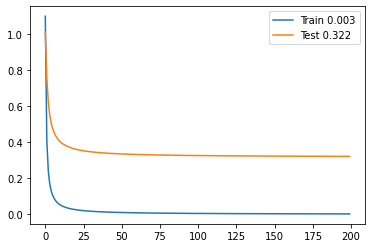

In [9]:
losses = [[], []]
for e in range(2000):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)

        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
        
        plt.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        plt.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        
        plt.legend()
        plt.show()

In [10]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)
optimF = Adam(netR.parameters(), lr=1e-4)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

L2 = nn.MSELoss()

weak_loader = WeakDataset(X_weak, batch_size=256, device=cfg["device"])

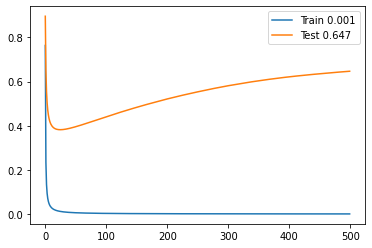

In [11]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())


        
        X_batch_weak = weak_loader.sample()
        optimR.zero_grad()
        optimF.zero_grad()
        loss_weak = -0.001*flow.log_prob(netR(X_batch_weak)).mean()
        loss_weak.backward(retain_graph=True)
        optimF.step()
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)

        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
        
        plt.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        plt.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        
        plt.legend()
        plt.show()

### Sinkhorn Regularization

In [420]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

L2 = nn.MSELoss()

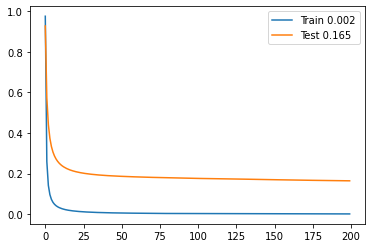

In [421]:
losses = [[], []]
for e in range(2000):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)

        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
        
        plt.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        plt.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        
        plt.legend()
        plt.show()

In [422]:
class Wasserstein():
    
    def __init__(self, eps, device=torch.device("cpu")):
        self.eps = eps
        self.device = device
        
    def forward(self, a, b, C, n_iter=100):
        K = torch.exp(-C/self.eps)
        v = torch.ones(b.shape[0], device=self.device)
        for _ in range(n_iter):
            u = a / (K@v)
            v = b / (K.T@u)
            
        return ((torch.diag(u)@K)@torch.diag(v))
        
    def __call__(self, a, b, C, n_iter=100):
        return self.forward(a, b, C, n_iter)

In [423]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

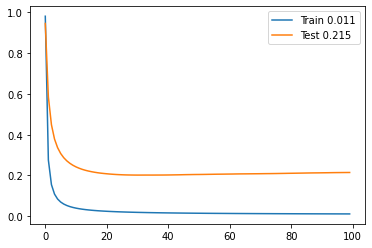

In [424]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_batch, y_weak, p=2)
        with torch.no_grad():
            a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
            b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
            P = W(a, b, C/C.max(), 20)
            
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch) + 0.01*(P*C).sum()
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)

        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
        
        plt.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        plt.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        
        plt.legend()
        plt.show()

In [432]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

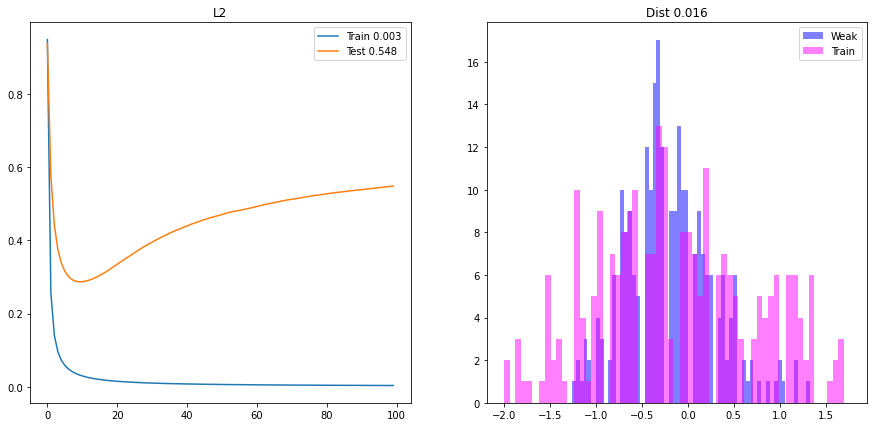

In [433]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_batch, y_weak, p=2)
        with torch.no_grad():
            C_X = torch.cdist(X_batch, X_batch_weak, p=2)
            a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
            b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
            P = W(a, b, C_X/C_X.max(), 100)
            
        y_pred = netR(X_batch)
        L2_loss = L2(y_pred, y_batch)
        W_loss = 0.01*(P*C).sum() + L2_loss
        loss = W_loss
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

### Softmin reg

In [448]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

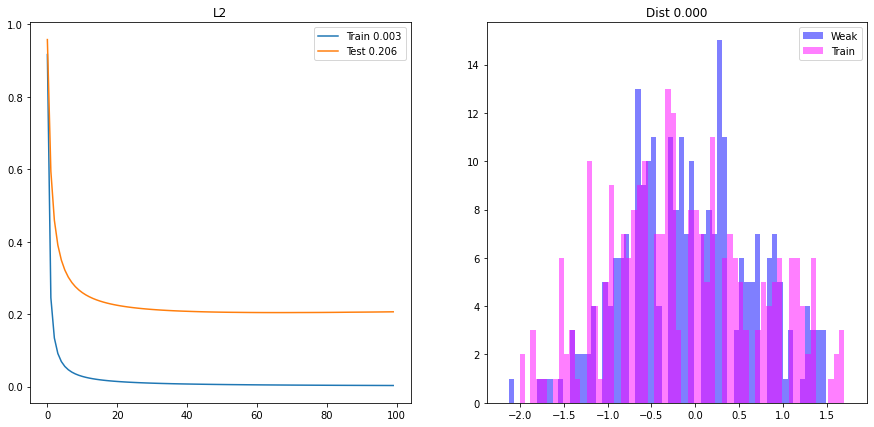

In [449]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_weak, y_batch, p=2)
        with torch.no_grad():
            C_X = torch.nn.functional.softmin(torch.cdist(X_batch_weak, X_batch, p=2), dim=1)
            
        y_pred = netR(X_batch)
        L2_loss = L2(y_pred, y_batch)
        W_loss = 0.0001*(C_X*C).sum(1).mean() + L2_loss
        loss = W_loss
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

### Experiments

In [286]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])
X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=min(cfg["batch_size"], cfg_dataset["n_samples_train"]), device=cfg["device"])

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

In [287]:
results_regr = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(loss.item())


        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr["Train"].append(losses[0])
    results_regr["Test"].append(losses[1])

Train 0.002, Test 0.426: 100% 2500/2500 [00:03<00:00, 640.77it/s]
Train 0.002, Test 0.367: 100% 2500/2500 [00:03<00:00, 645.59it/s]
Train 0.002, Test 0.359: 100% 2500/2500 [00:03<00:00, 632.45it/s]
Train 0.002, Test 0.360: 100% 2500/2500 [00:04<00:00, 567.22it/s]
Train 0.002, Test 0.349: 100% 2500/2500 [00:04<00:00, 571.44it/s]
Train 0.002, Test 0.358: 100% 2500/2500 [00:04<00:00, 602.63it/s]
Train 0.002, Test 0.385: 100% 2500/2500 [00:03<00:00, 641.30it/s]
Train 0.002, Test 0.344: 100% 2500/2500 [00:03<00:00, 642.01it/s]
Train 0.002, Test 0.357: 100% 2500/2500 [00:03<00:00, 634.18it/s]
Train 0.002, Test 0.326: 100% 2500/2500 [00:04<00:00, 613.50it/s]
Train 0.002, Test 0.320: 100% 2500/2500 [00:04<00:00, 575.63it/s]
Train 0.002, Test 0.321: 100% 2500/2500 [00:04<00:00, 564.83it/s]
Train 0.002, Test 0.353: 100% 2500/2500 [00:04<00:00, 595.41it/s]
Train 0.002, Test 0.377: 100% 2500/2500 [00:03<00:00, 659.17it/s]
Train 0.002, Test 0.317: 100% 2500/2500 [00:03<00:00, 648.95it/s]
Train 0.00

In [288]:
results_regr_with_gan = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    optimD = Adam(netD.parameters(), lr=1e-2)
    optimG = Adam(netR.parameters(), lr=1e-3)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Descriminator
            for j in range(cfg['iter_d']):
                optimD.zero_grad()
                X_batch_weak = weak_loader.sample()

                with torch.no_grad():
                    fake = netR(X_batch_weak)
                    real = y_batch

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()

                netD_loss = e_fake - e_real

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                netD_total_loss.backward()
                optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            optimR.zero_grad()

            fake = netR(X_batch_weak)
            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            netG_loss_total = 0.01*netG_loss
            netG_loss_total.backward()
            optimG.step()
            
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()
            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr_with_gan["Train"].append(losses[0])
    results_regr_with_gan["Test"].append(losses[1])

Train 0.003, Test 0.486: 100% 2500/2500 [02:03<00:00, 20.22it/s]
Train 0.002, Test 0.313: 100% 2500/2500 [02:03<00:00, 20.28it/s]
Train 0.002, Test 0.411: 100% 2500/2500 [02:04<00:00, 20.05it/s]
Train 0.002, Test 0.548: 100% 2500/2500 [02:04<00:00, 20.10it/s]
Train 0.002, Test 0.546: 100% 2500/2500 [02:03<00:00, 20.22it/s]
Train 0.002, Test 0.365: 100% 2500/2500 [02:03<00:00, 20.21it/s]
Train 0.002, Test 0.392: 100% 2500/2500 [02:05<00:00, 19.88it/s]
Train 0.003, Test 0.553:  77% 1936/2500 [01:41<00:27, 20.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train 0.002, Test 0.587: 100% 2500/2500 [02:11<00:00, 18.94it/s]
Train 0.005, Test 0.432:  52% 1305/2500 [01:24<01:31, 13.02it/s]IOPub message rate exceeded

In [289]:
results_regr_with_rand_gan = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    optimD = Adam(netD.parameters(), lr=1e-2)
    optimG = Adam(netR.parameters(), lr=1e-3)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Descriminator
            for j in range(cfg['iter_d']):
                optimD.zero_grad()
                X_batch_weak = weak_loader.sample()
                X_batch_weak *= torch.normal(1, 0.1, (X_batch_weak.shape), device=cfg['device'])

                with torch.no_grad():
                    fake = netR(X_batch_weak)
                    real = y_batch

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()

                netD_loss = e_fake - e_real

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                netD_total_loss.backward()
                optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            optimR.zero_grad()

            fake = netR(X_batch_weak)
            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            netG_loss_total = 0.01*netG_loss
            netG_loss_total.backward()
            optimG.step()
            
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()
            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr_with_rand_gan["Train"].append(losses[0])
    results_regr_with_rand_gan["Test"].append(losses[1])

Train 0.002, Test 0.424:  82% 2038/2500 [01:50<00:26, 17.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train 0.002, Test 0.382: 100% 2500/2500 [02:12<00:00, 18.86it/s]
Train 0.004, Test 0.419:  48% 1206/2500 [01:07<01:05, 19.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train 0.002, Test 0.583: 100% 2500/2500 [02:09<00:00, 19.31it/s]
Train 0.041, Test 0.429:   5% 129/2500 [00:06<01:58, 20.08it/s]IOPub message rate exceeded.


In [290]:
results_regr_with_gan_1e4 = {"Train":[], "Test":[]}

for _ in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)
    optimD = Adam(netD.parameters(), lr=1e-2)
    optimG = Adam(netR.parameters(), lr=1e-4)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Descriminator
            for j in range(cfg['iter_d']):
                optimD.zero_grad()
                X_batch_weak = weak_loader.sample()

                with torch.no_grad():
                    fake = netR(X_batch_weak)
                    real = y_batch

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()

                netD_loss = e_fake - e_real

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                netD_total_loss.backward()
                optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            optimR.zero_grad()

            fake = netR(X_batch_weak)
            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            netG_loss_total = 0.01*netG_loss
            netG_loss_total.backward()
            optimG.step()
            
            ### Regressor
            optimR.zero_grad()
            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            loss.backward()
            optimR.step()
            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("Train {:.3f}, Test {:.3f}".format(losses[0][-1], losses[1][-1]))
        
    results_regr_with_gan_1e4["Train"].append(losses[0])
    results_regr_with_gan_1e4["Test"].append(losses[1])

Train 0.002, Test 0.293: 100% 2500/2500 [02:04<00:00, 20.04it/s]
Train 0.002, Test 0.303: 100% 2500/2500 [02:03<00:00, 20.21it/s]
Train 0.002, Test 0.469: 100% 2500/2500 [02:04<00:00, 20.02it/s]
Train 0.002, Test 0.348: 100% 2500/2500 [02:07<00:00, 19.64it/s]
Train 0.002, Test 0.212: 100% 2500/2500 [02:15<00:00, 18.49it/s]
Train 0.002, Test 0.205: 100% 2500/2500 [02:10<00:00, 19.12it/s]
Train 0.002, Test 0.294: 100% 2500/2500 [02:17<00:00, 18.24it/s]
Train 0.002, Test 0.352: 100% 2500/2500 [02:09<00:00, 19.33it/s]
Train 0.002, Test 0.324: 100% 2500/2500 [02:13<00:00, 18.71it/s]
Train 0.002, Test 0.243: 100% 2500/2500 [02:12<00:00, 18.92it/s]
Train 0.002, Test 0.412: 100% 2500/2500 [02:07<00:00, 19.62it/s]
Train 0.002, Test 0.312: 100% 2500/2500 [02:08<00:00, 19.46it/s]
Train 0.002, Test 0.246: 100% 2500/2500 [02:22<00:00, 17.54it/s]
Train 0.002, Test 0.261: 100% 2500/2500 [02:08<00:00, 19.48it/s]
Train 0.002, Test 0.324: 100% 2500/2500 [02:14<00:00, 18.58it/s]
Train 0.002, Test 0.386: 

In [291]:
results_regr_with_W = {"Train":[], "Test":[]}

for iteration in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            X_batch_weak = weak_loader.sample()
            y_weak = netR(X_batch_weak)
            C = torch.cdist(y_batch, y_weak, p=2)
            with torch.no_grad():
                a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
                b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
                P = W(a, b, C/C.max(), 200)

            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch) + 0.001*(P*C).sum()
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("{} Train {:.3f}, Test {:.3f}".format(iteration, losses[0][-1], losses[1][-1]))
        
    results_regr_with_W["Train"].append(losses[0])
    results_regr_with_W["Test"].append(losses[1])

0 Train 0.003, Test 0.316: 100% 2500/2500 [00:27<00:00, 91.19it/s]
1 Train 0.002, Test 0.336: 100% 2500/2500 [00:27<00:00, 92.24it/s]
2 Train 0.002, Test 0.255: 100% 2500/2500 [00:28<00:00, 87.65it/s]
3 Train 0.003, Test 0.317: 100% 2500/2500 [00:28<00:00, 88.67it/s]
4 Train 0.002, Test 0.351: 100% 2500/2500 [00:27<00:00, 91.40it/s]
5 Train 0.003, Test 0.370: 100% 2500/2500 [00:27<00:00, 91.01it/s]
6 Train 0.003, Test 0.279: 100% 2500/2500 [00:27<00:00, 91.84it/s]
7 Train 0.003, Test 0.474: 100% 2500/2500 [00:27<00:00, 91.56it/s]
8 Train 0.002, Test 0.360: 100% 2500/2500 [00:27<00:00, 92.16it/s]
9 Train 0.003, Test 0.307: 100% 2500/2500 [00:27<00:00, 90.13it/s]
10 Train 0.002, Test 0.279: 100% 2500/2500 [00:27<00:00, 89.82it/s]
11 Train 0.002, Test 0.257: 100% 2500/2500 [00:27<00:00, 90.07it/s]
12 Train 0.003, Test 0.212: 100% 2500/2500 [00:27<00:00, 89.50it/s]
13 Train 0.003, Test 0.330: 100% 2500/2500 [00:28<00:00, 88.45it/s]
14 Train 0.002, Test 0.353: 100% 2500/2500 [00:27<00:00, 9

In [292]:
results_regr_with_W_weighted = {"Train":[], "Test":[]}

for iteration in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            X_batch_weak = weak_loader.sample()
            y_weak = netR(X_batch_weak)
            C = torch.cdist(y_batch, y_weak, p=2)
            with torch.no_grad():
                a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
                b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
                P = W(a, b, C/C.max(), 200)

            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            L2_loss = loss.item()
            loss += 0.1*L2_loss*(P*C).sum()
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(L2_loss)

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("{} Train {:.3f}, Test {:.3f}".format(iteration, losses[0][-1], losses[1][-1]))
        
    results_regr_with_W_weighted["Train"].append(losses[0])
    results_regr_with_W_weighted["Test"].append(losses[1])

0 Train 0.002, Test 0.482: 100% 2500/2500 [00:27<00:00, 91.07it/s]
1 Train 0.002, Test 0.416: 100% 2500/2500 [00:27<00:00, 90.68it/s]
2 Train 0.002, Test 0.403: 100% 2500/2500 [00:27<00:00, 90.26it/s]
3 Train 0.002, Test 0.279: 100% 2500/2500 [00:28<00:00, 88.40it/s]
4 Train 0.002, Test 0.375: 100% 2500/2500 [00:28<00:00, 88.42it/s]
5 Train 0.002, Test 0.297: 100% 2500/2500 [00:27<00:00, 90.44it/s]
6 Train 0.002, Test 0.395: 100% 2500/2500 [00:27<00:00, 89.47it/s]
7 Train 0.002, Test 0.330: 100% 2500/2500 [00:29<00:00, 85.25it/s]
8 Train 0.002, Test 0.331: 100% 2500/2500 [00:27<00:00, 91.07it/s]
9 Train 0.002, Test 0.311: 100% 2500/2500 [00:27<00:00, 90.13it/s]
10 Train 0.002, Test 0.304: 100% 2500/2500 [00:27<00:00, 91.82it/s]
11 Train 0.002, Test 0.355: 100% 2500/2500 [00:27<00:00, 91.19it/s]
12 Train 0.002, Test 0.330: 100% 2500/2500 [00:27<00:00, 90.15it/s]
13 Train 0.002, Test 0.310: 100% 2500/2500 [00:27<00:00, 90.35it/s]
14 Train 0.002, Test 0.376: 100% 2500/2500 [00:28<00:00, 8

In [299]:
results_regr_with_W_1e4 = {"Train":[], "Test":[]}

for iteration in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            X_batch_weak = weak_loader.sample()
            y_weak = netR(X_batch_weak)
            C = torch.cdist(y_batch, y_weak, p=2)
            with torch.no_grad():
                a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
                b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
                P = W(a, b, C/C.max(), 20)

            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch) + 0.0001*(P*C).sum()
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("{} Train {:.3f}, Test {:.3f}".format(iteration, losses[0][-1], losses[1][-1]))
        
    results_regr_with_W_1e4["Train"].append(losses[0])
    results_regr_with_W_1e4["Test"].append(losses[1])

0 Train 0.002, Test 0.277: 100% 2500/2500 [00:29<00:00, 84.24it/s]
1 Train 0.002, Test 0.278: 100% 2500/2500 [00:27<00:00, 90.53it/s]
2 Train 0.002, Test 0.382: 100% 2500/2500 [00:27<00:00, 89.74it/s]
3 Train 0.002, Test 0.280: 100% 2500/2500 [00:27<00:00, 92.11it/s]
4 Train 0.002, Test 0.342: 100% 2500/2500 [00:26<00:00, 92.62it/s]
5 Train 0.002, Test 0.367: 100% 2500/2500 [00:27<00:00, 91.31it/s]
6 Train 0.002, Test 0.289: 100% 2500/2500 [00:26<00:00, 92.72it/s]
7 Train 0.002, Test 0.371: 100% 2500/2500 [00:27<00:00, 91.51it/s]
8 Train 0.002, Test 0.269: 100% 2500/2500 [00:28<00:00, 89.15it/s]
9 Train 0.002, Test 0.246: 100% 2500/2500 [00:27<00:00, 92.09it/s]
10 Train 0.002, Test 0.309: 100% 2500/2500 [00:27<00:00, 91.13it/s]
11 Train 0.002, Test 0.345: 100% 2500/2500 [00:27<00:00, 92.03it/s]
12 Train 0.002, Test 0.230: 100% 2500/2500 [00:27<00:00, 91.89it/s]
13 Train 0.002, Test 0.355: 100% 2500/2500 [00:26<00:00, 92.74it/s]
14 Train 0.002, Test 0.397: 100% 2500/2500 [00:26<00:00, 9

In [301]:
results_regr_with_W_1e2 = {"Train":[], "Test":[]}

for iteration in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            X_batch_weak = weak_loader.sample()
            y_weak = netR(X_batch_weak)
            C = torch.cdist(y_batch, y_weak, p=2)
            with torch.no_grad():
                a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
                b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
                P = W(a, b, C/C.max(), 20)

            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch) + 0.01*(P*C).sum()
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(loss.item())

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("{} Train {:.3f}, Test {:.3f}".format(iteration, losses[0][-1], losses[1][-1]))
        
    results_regr_with_W_1e2["Train"].append(losses[0])
    results_regr_with_W_1e2["Test"].append(losses[1])

0 Train 0.006, Test 0.414: 100% 2500/2500 [00:07<00:00, 318.57it/s]
1 Train 0.007, Test 0.411: 100% 2500/2500 [00:07<00:00, 317.78it/s]
2 Train 0.007, Test 0.369: 100% 2500/2500 [00:07<00:00, 315.96it/s]
3 Train 0.007, Test 0.288: 100% 2500/2500 [00:07<00:00, 318.02it/s]
4 Train 0.007, Test 0.317: 100% 2500/2500 [00:07<00:00, 316.75it/s]
5 Train 0.007, Test 0.343: 100% 2500/2500 [00:08<00:00, 305.33it/s]
6 Train 0.007, Test 0.355: 100% 2500/2500 [00:07<00:00, 315.63it/s]
7 Train 0.006, Test 0.311: 100% 2500/2500 [00:07<00:00, 318.20it/s]
8 Train 0.006, Test 0.317: 100% 2500/2500 [00:07<00:00, 314.57it/s]
9 Train 0.007, Test 0.253: 100% 2500/2500 [00:07<00:00, 317.36it/s]
10 Train 0.007, Test 0.291: 100% 2500/2500 [00:07<00:00, 319.08it/s]
11 Train 0.007, Test 0.468: 100% 2500/2500 [00:07<00:00, 318.85it/s]
12 Train 0.007, Test 0.476: 100% 2500/2500 [00:07<00:00, 317.64it/s]
13 Train 0.007, Test 0.448: 100% 2500/2500 [00:07<00:00, 316.24it/s]
14 Train 0.007, Test 0.284: 100% 2500/2500 [

In [305]:
results_regr_with_W_weighted_Pure = {"Train":[], "Test":[]}

for iteration in range(20):
    netR = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    optimR = Adam(netR.parameters(), lr=1e-2)

    meter_names = ['L2_Loss_Train','L2_Loss_Test']
    meters = create_meters(meter_names)

    losses = [[], []]

    for e in (pbar := tqdm(range(cfg['num_epochs']))):
        for X_batch, y_batch in train_loader:
            ### Regressor
            optimR.zero_grad()
            X_batch_weak = weak_loader.sample()
            y_weak = netR(X_batch_weak)
            C = torch.cdist(y_batch, y_weak, p=2)
            with torch.no_grad():
                a = torch.ones((y_batch.shape[0],), device=cfg["device"])/y_batch.shape[0]
                b = torch.ones((y_weak.shape[0],), device=cfg["device"])/y_weak.shape[0]
                P = W(a, b, C/C.max(), 20)

            y_pred = netR(X_batch)
            loss = L2(y_pred, y_batch)
            L2_loss = loss.item()
            loss += L2_loss*(P*C).sum()
            loss.backward()
            optimR.step()

            meters["L2_Loss_Train"].update(L2_loss)

        if not e % cfg["display_freq"]:
            with torch.no_grad():
                y_pred = netR(X_test_torch)
                loss = L2(y_pred, y_test_torch).item()

            meters["L2_Loss_Test"].update(loss)

            losses[0].append(meters["L2_Loss_Train"].avg)
            losses[1].append(meters["L2_Loss_Test"].avg)
        pbar.set_description("{} Train {:.3f}, Test {:.3f}".format(iteration, losses[0][-1], losses[1][-1]))
        
    results_regr_with_W_weighted_Pure["Train"].append(losses[0])
    results_regr_with_W_weighted_Pure["Test"].append(losses[1])

0 Train 0.002, Test 0.420: 100% 2500/2500 [00:07<00:00, 316.36it/s]
1 Train 0.002, Test 0.330: 100% 2500/2500 [00:07<00:00, 315.91it/s]
2 Train 0.003, Test 0.370: 100% 2500/2500 [00:07<00:00, 317.92it/s]
3 Train 0.002, Test 0.416: 100% 2500/2500 [00:07<00:00, 315.48it/s]
4 Train 0.002, Test 0.512: 100% 2500/2500 [00:07<00:00, 315.13it/s]
5 Train 0.002, Test 0.483: 100% 2500/2500 [00:07<00:00, 317.09it/s]
6 Train 0.002, Test 0.363: 100% 2500/2500 [00:07<00:00, 319.34it/s]
7 Train 0.002, Test 0.423: 100% 2500/2500 [00:07<00:00, 319.27it/s]
8 Train 0.002, Test 0.417: 100% 2500/2500 [00:07<00:00, 318.38it/s]
9 Train 0.003, Test 0.505: 100% 2500/2500 [00:07<00:00, 318.05it/s]
10 Train 0.002, Test 0.437: 100% 2500/2500 [00:07<00:00, 319.07it/s]
11 Train 0.002, Test 0.477: 100% 2500/2500 [00:07<00:00, 321.78it/s]
12 Train 0.003, Test 0.447: 100% 2500/2500 [00:07<00:00, 319.75it/s]
13 Train 0.002, Test 0.343: 100% 2500/2500 [00:07<00:00, 316.47it/s]
14 Train 0.003, Test 0.283: 100% 2500/2500 [

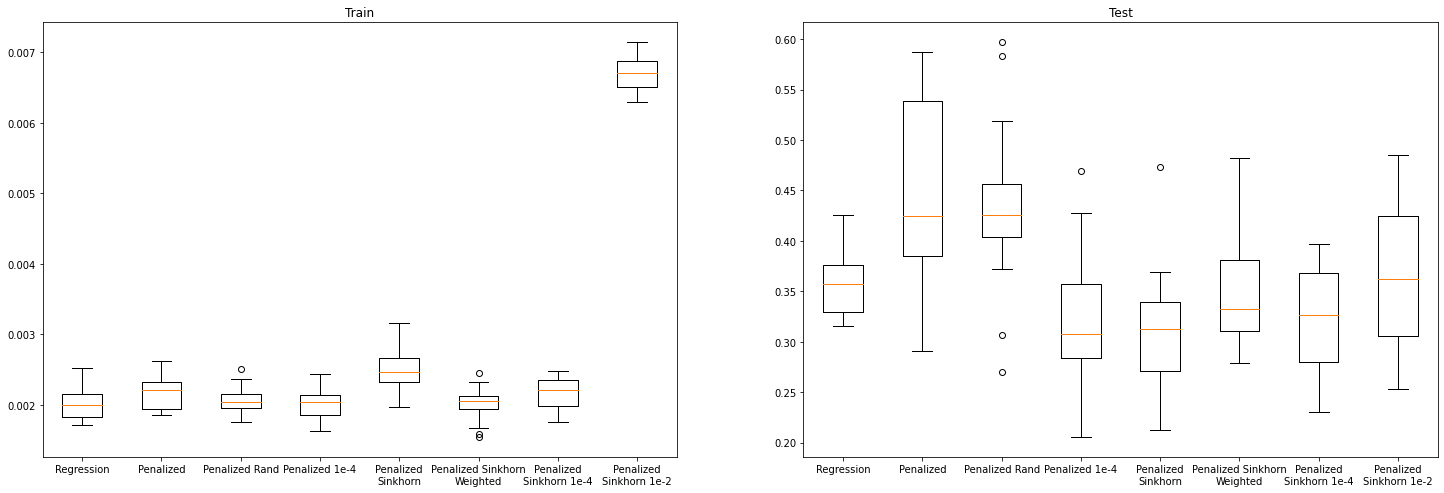

In [302]:
plt.figure(figsize=(25, 8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title("Train")
ax1.boxplot([
    [i[-1] for i in results_regr["Train"]],
    [i[-1] for i in results_regr_with_gan["Train"]],
    [i[-1] for i in results_regr_with_rand_gan["Train"]],
    [i[-1] for i in results_regr_with_gan_1e4["Train"]],
    [i[-1] for i in results_regr_with_W["Train"]],
    [i[-1] for i in results_regr_with_W_weighted["Train"]],
    [i[-1] for i in results_regr_with_W_1e4["Train"]],
    [i[-1] for i in results_regr_with_W_1e2["Train"]],
    ],
    labels = ["Regression", 
              "Penalized", 
              "Penalized Rand", 
              "Penalized 1e-4", 
              "Penalized\nSinkhorn", 
              "Penalized Sinkhorn\nWeighted", 
              "Penalized\nSinkhorn 1e-4", 
              "Penalized\nSinkhorn 1e-2"]
)


ax2.set_title("Test")
ax2.boxplot([
    [i[-1] for i in results_regr["Test"]],
    [i[-1] for i in results_regr_with_gan["Test"]],
    [i[-1] for i in results_regr_with_rand_gan["Test"]],
    [i[-1] for i in results_regr_with_gan_1e4["Test"]],
    [i[-1] for i in results_regr_with_W["Test"]],
    [i[-1] for i in results_regr_with_W_weighted["Test"]],
    [i[-1] for i in results_regr_with_W_1e4["Test"]],
    [i[-1] for i in results_regr_with_W_1e2["Test"]],
    ],
    labels = ["Regression", 
              "Penalized", 
              "Penalized Rand", 
              "Penalized 1e-4", 
              "Penalized\nSinkhorn", 
              "Penalized Sinkhorn\nWeighted", 
              "Penalized\nSinkhorn 1e-4", 
              "Penalized\nSinkhorn 1e-2"]
)
plt.show()